The RDKit supports a number of different fingerprinting algorithms and fingerprint types. For historical reasons (i.e. "bad decisions made a long time ago") these are accessed via an inconsistent and confusing set of function names. Boran Adas, a student doing a Google Summer of Code project back in 2018, added a new API with a consistent interface for a number of the fingerprint types. I've mentioned this a few times and used it in some blog posts, but it has remained "underdocumented". This blog post is an attempt to remedy that. Some of this content will end up in a future version of the RDKit docs.



In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
print(rdkit.__version__)
%pylab inline

2022.09.1
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Start by getting some molecules to work with

In [2]:
ms = [x for x in Chem.SmilesMolSupplier('../data/BLSets_selected_actives.txt') if x.GetProp('_Name')=='CHEMBL204']
len(ms)

452

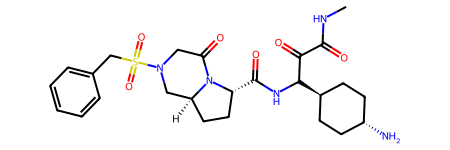

In [3]:
ms[0]

# Generators and fingerprints

The idea of the new code is that all supported fingerprinting algorithms can be used the same way: you create a generator for that fingerprint algorithm with the appropriate parameters set and then ask the generator to give you the fingerprint type you want for each molecule.

Let's look at how that works for Morgan fingerprints. When we create the generator we can optionally provide the radius and the size of the fingerprints to be generated:

In [4]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

The fingerprint generator knows how to create four separate types of fingerprints:
1. `fpgen.GetFingerprint(m)`: returns a bit vector of size `fpSize`
2. `fpgen.GetCountFingerprint(m)`: returns a count vector of size `fpSize`
3. `fpgen.GetSparseFingerprint(m)`: returns a sparse bit vector
4. `fpgen.GetSparseCountFingerprint(m)`: returns a sparse count vector

The sparse bit and count vectors are of variable size, depending on the fingerprint type, but are always very large (at least $2^{32}-1$).

Here's a demonstration of that:

In [5]:
# bit vectors:
fp = mfpgen.GetFingerprint(ms[0])
sfp = mfpgen.GetSparseFingerprint(ms[0])

# count vectors:
cfp = mfpgen.GetCountFingerprint(ms[0])
scfp = mfpgen.GetSparseCountFingerprint(ms[0])

In [6]:
print(f'fp: {type(fp)} {len(fp)}')
print(f'sfp: {type(sfp)} {len(sfp)}')
print(f'cfp: {type(cfp)} {cfp.GetLength()}')
print(f'scfp: {type(scfp)} {scfp.GetLength()}')

fp: <class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'> 2048
sfp: <class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 4294967295
cfp: <class 'rdkit.DataStructs.cDataStructs.UIntSparseIntVect'> 2048
scfp: <class 'rdkit.DataStructs.cDataStructs.ULongSparseIntVect'> 18446744073709551615


# Basic usage

As of this writing (RDKit v2022.09), the fingerprinting algorithms supported by the fingerprint generators are:
1. Morgan
2. Feature Morgan (this is a variation of the Morgan fingerprint)
3. RDKit
4. Atom pairs
5. Topological torsions

I already showed how to generate Morgan fingerprints, creating generators for the other types looks the same:

In [7]:
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
apgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=2048)
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048)

Feature Morgan fingerprints are created using a Morgan generator which uses a different method of assigning atom invariants (atom types):

In [8]:
fmgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2,
                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganFeatureAtomInvGen())

And the generators all have the same API for creating fingerprints:

In [9]:
rdkfp = rdkgen.GetFingerprint(ms[0])
apfp = apgen.GetFingerprint(ms[0])
ttfp = ttgen.GetFingerprint(ms[0])

Parameters specific to the individual fingerprint algorithms can be provided when creating the generator. We saw this above for the Morgan fingerprint, here's an example of changing the max path length used for the RDKit FP:

In [10]:
rdk5gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=2048)
rdk5gen.GetFingerprint(ms[0]).GetNumOnBits(),rdkgen.GetFingerprint(ms[0]).GetNumOnBits()

(339, 984)

The default RDKit FP generator, which uses a max path length of 7, sets many more bits.

You can find out which options are available by introspecting the functions which create generators:

In [11]:
help(rdFingerprintGenerator.GetRDKitFPGenerator)

Help on built-in function GetRDKitFPGenerator in module rdkit.Chem.rdFingerprintGenerator:

GetRDKitFPGenerator(...)
    GetRDKitFPGenerator([  (int)minPath=1 [, (int)maxPath=7 [, (bool)useHs=True [, (bool)branchedPaths=True [, (bool)useBondOrder=True [, (bool)countSimulation=False [, (object)countBounds=None [, (int)fpSize=2048 [, (int)numBitsPerFeature=2 [, (object)atomInvariantsGenerator=None]]]]]]]]]]) -> FingerprintGenerator64 :
        Get an RDKit fingerprint generator
        
          ARGUMENTS:
            - minPath: the minimum path length (in bonds) to be included
            - maxPath: the maximum path length (in bonds) to be included
            - useHs: toggles inclusion of Hs in paths (if the molecule has explicit Hs)
            - branchedPaths: toggles generation of branched subgraphs, not just linear paths
            - useBondOrder: toggles inclusion of bond orders in the path hashes
            - countSimulation:  if set, use count simulation while  generating the

As always with the RDKit, we try to keep the documentation up to date, so hopefully the docstrings are complete and correct. The automatically generate function signature, on the other hand, are always right. These show you all of the arguments and their default values:
```
GetRDKitFPGenerator([  (int)minPath=1 [, (int)maxPath=7 [, (bool)useHs=True [, (bool)branchedPaths=True [, (bool)useBondOrder=True [, (bool)countSimulation=False [, (object)countBounds=None [, (int)fpSize=2048 [, (int)numBitsPerFeature=2 [, (object)atomInvariantsGenerator=None]]]]]]]]]]) -> FingerprintGenerator64
```

# Additional information / Explaining bits

The fingerprint generators can provide the information required to "explain" fingerprint bits. This is accessed using the additionalOutput argument when creating a fingerprint.

Since the different fingerprint algorithms use different types of atom/bond environments to set bits, the information available (or the interpretation of the information available) for the generators is different.

Here's an example with Morgan fingerprints:

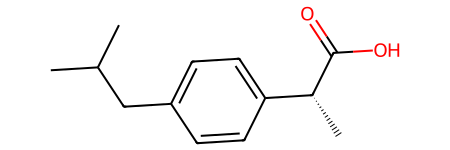

In [12]:
ibuprofen = Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O')
ibuprofen

In [13]:
mfp1gen = rdFingerprintGenerator.GetMorganGenerator(radius=1)

ao = rdFingerprintGenerator.AdditionalOutput()
# we have to ask for the information we're interested in by allocating space for it:
ao.AllocateAtomCounts()
ao.AllocateAtomToBits()
ao.AllocateBitInfoMap()

fp = mfp1gen.GetFingerprint(ibuprofen,additionalOutput=ao)

The mapping of bit numbers to central atom and radius:

In [14]:
ao.GetBitInfoMap()

{1: ((1, 0), (10, 0)),
 79: ((3, 1),),
 80: ((3, 0),),
 283: ((0, 1), (2, 1), (11, 1)),
 389: ((14, 1),),
 650: ((13, 0),),
 807: ((12, 0), (14, 0)),
 900: ((10, 1),),
 1057: ((0, 0), (2, 0), (11, 0)),
 1365: ((7, 1),),
 1380: ((4, 0), (7, 0)),
 1750: ((5, 1), (6, 1), (8, 1), (9, 1)),
 1754: ((4, 1),),
 1844: ((12, 1),),
 1847: ((1, 1),),
 1873: ((5, 0), (6, 0), (8, 0), (9, 0)),
 1917: ((13, 1),)}

The number of bits each atom sets:

In [15]:
ao.GetAtomCounts()

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

That's a tuple N atoms long with the number of bits each atoms sets

Which bits each atom sets:

In [16]:
ao.GetAtomToBits()

((1057, 283),
 (1, 1847),
 (1057, 283),
 (80, 79),
 (1380, 1754),
 (1873, 1750),
 (1873, 1750),
 (1380, 1365),
 (1873, 1750),
 (1873, 1750),
 (1, 900),
 (1057, 283),
 (807, 1844),
 (650, 1917),
 (807, 389))

That's a tuple N atoms long with a tuple of bit indices for each atom.

As mentioned above, different information may be available for different fingerprints.

Every generator can provide the atom counts and atom to bits list.

The generators provide more detailed information using either the bitInfoMap or bitPaths options in AdditionalOutput. Here's what those mean for the individual generators:

- Morgan: `bitInfoMap` provides (center atom, radius) tuples
- RDKit: `bitPaths` provides tuples with the bond indices involved in the subgraphs
- TopologicalTorsion: `bitPaths` provides tuples with the atom indices involved in the paths
- AtomPair: `bitInfoMap` provides (atom1, atom2) tuples



Here's an example of the atom paths for topological torsions:

In [17]:
# disable count simulation because there was a bug with the additional output and count
# simulation until the 2022.09.4 release:
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(countSimulation=False)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()

fp = ttgen.GetFingerprint(ibuprofen,additionalOutput=ao)
ao.GetBitPaths()

{95: ((5, 4, 9, 8), (5, 6, 7, 8), (6, 5, 4, 9), (6, 7, 8, 9)),
 163: ((7, 10, 12, 13),),
 169: ((0, 1, 3, 4), (2, 1, 3, 4)),
 171: ((7, 10, 12, 14),),
 620: ((6, 7, 10, 11), (8, 7, 10, 11)),
 941: ((11, 10, 12, 13),),
 949: ((11, 10, 12, 14),),
 1172: ((5, 6, 7, 10), (9, 8, 7, 10)),
 1353: ((3, 4, 5, 6), (3, 4, 9, 8)),
 1905: ((1, 3, 4, 5), (1, 3, 4, 9)),
 1975: ((6, 7, 10, 12), (8, 7, 10, 12)),
 2009: ((4, 5, 6, 7), (4, 9, 8, 7))}

In [18]:
ms[0].GetNumBonds(),ms[0].GetNumAtoms()

(40, 37)

In [19]:
m = Chem.MolFromSmiles('CCCC')
fp = ttgen.GetFingerprint(m,additionalOutput=ao)
ao.GetBitPaths()

{15: ((0, 1, 2, 3),)}

In [20]:
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator()
fp = rdkgen.GetFingerprint(m,additionalOutput=ao)
ao.GetBitPaths()

{709: ((0, 1), (1, 2)),
 875: ((0, 1, 2),),
 1308: ((0,), (1,), (2,)),
 1772: ((0,), (1,), (2,)),
 1813: ((0, 1), (1, 2)),
 1927: ((0, 1, 2),)}

In [22]:
apgen = rdFingerprintGenerator.GetAtomPairGenerator(countSimulation=False)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()

fp = apgen.GetFingerprint(ibuprofen,additionalOutput=ao)
ao.GetBitInfoMap()[312]

((4, 6), (4, 8), (5, 7), (7, 9))

# Some advanced topics

## Count simulation

It's possible to simulate count-based fingerprints using bit vector fingerprints. I've discussed this in [another blog post](https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-simulating-counts.html) and there's a description in the [section of the RDKit book](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints) about atom pair and topological torsion fingerprints, so I won't get into heavy detail here.

The fingerprint generators allow you to use count simulation for every fingerprint algorithm. It's enabled by default for atom pairs and topological torsions, but you can also use it with the other fingerprints by using the keyword argument `countSimulation=True` when constructing the fingerprints

Here's a quick demo of the impact that has with the Morgan fingerprint for the set of molecules we loaded here.

In [68]:
from rdkit import DataStructs
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
# for a direct comparison we need to use a fingerprint 4 times as long:
simfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096,countSimulation=True)
fps = [fpgen.GetFingerprint(m) for m in ms]
countfps = [fpgen.GetCountFingerprint(m) for m in ms]
simfps = [simfpgen.GetFingerprint(m) for m in ms]

countsims = []
sims = []
simsims = []
for i in range(len(ms)//2):
    for j in range(i+i,len(ms)//2):
        countsims.extend(DataStructs.BulkTanimotoSimilarity(countfps[i],countfps[j:]))
        sims.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[j:]))
        simsims.extend(DataStructs.BulkTanimotoSimilarity(simfps[i],simfps[j:]))


In [75]:
from scipy import stats

In [77]:
bvr,_ = stats.spearmanr(countsims,sims)
simr,_ = stats.spearmanr(countsims,simsims)
print(bvr,simr)

0.8353509796090909 0.9430970250118949


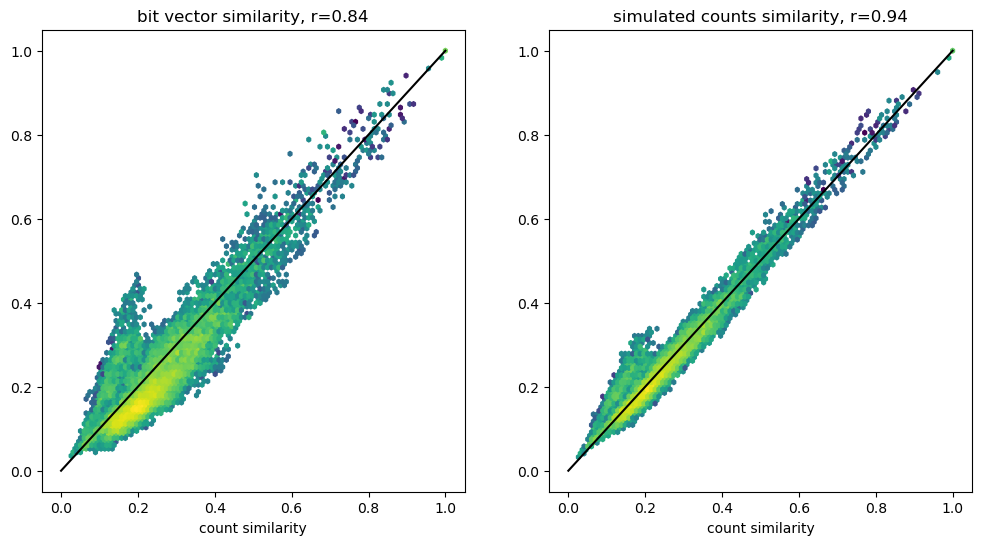

In [80]:
figsize(12,6)
subplot(1,2,1)
hexbin(countsims,sims,bins='log')
plot((0,1),(0,1),'k-')
title(f'bit vector similarity, r={bvr:.2f}')
xlabel('count similarity')
subplot(1,2,2)
hexbin(countsims,simsims,bins='log')
plot((0,1),(0,1),'k-')
title(f'simulated counts similarity, r={simr:.2f}')
xlabel('count similarity');



You can see that, in general, the count simulation results in closer similarity values.

## "Rooted" fingerprints

It's often useful to generate fingerprints which only include bits from particular atoms. We can easily do this with the fingerprint generators

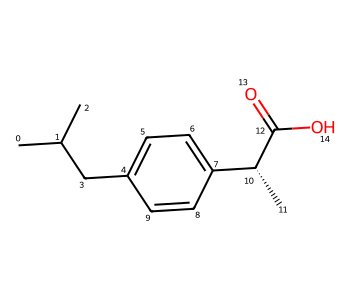

In [33]:
from rdkit.Chem import Draw
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True
Draw.MolToImage(ibuprofen,size=(350,300),options=opts)

In [44]:
# define a query which returns the C atom from a carboxyl group:
carboxyl = Chem.MolFromSmarts('[$(C(=O)[OH,O-])]')
matches = [x[0] for x in ibuprofen.GetSubstructMatches(carboxyl)]
matches

[12]

In [46]:
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator()

ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()

fp = ttgen.GetSparseCountFingerprint(ibuprofen,fromAtoms=matches,additionalOutput=ao)
ao.GetBitPaths()

{5645816361: ((6, 7, 10, 12), (8, 7, 10, 12))}

We can do the same thing with RDKit fingerprints, but since those involve bond indices, we need to see the those:

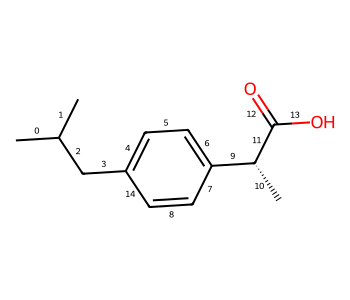

In [49]:
from rdkit.Chem import Draw
opts = Draw.MolDrawOptions()
opts.addBondIndices = True
Draw.MolToImage(ibuprofen,size=(350,300),options=opts)

In [52]:
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=3, # <- max of 3 bonds in the subgraph
                                                    numBitsPerFeature=1) # <- only set one bit per subgraph (the default is 2)

ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()

fp = rdkgen.GetSparseCountFingerprint(ibuprofen,fromAtoms=matches,additionalOutput=ao)
ao.GetBitPaths()

{733740352: ((11, 9, 7), (11, 9, 6)),
 1444346785: ((12, 13),),
 1461736417: ((11, 12),),
 1480085840: ((11, 12, 10),),
 1524090560: ((11, 13),),
 1728147184: ((11, 13, 12),),
 1940446997: ((11, 10),),
 2001612136: ((11, 9),),
 2172716083: ((12,),),
 2821383998: ((11, 13, 9),),
 3146241850: ((11, 10, 9),),
 3508377372: ((11, 12, 9),),
 3977409745: ((11, 13, 10),),
 4274652475: ((13,),),
 4275705116: ((11,),)}

Since the RDKit fingerprint can include branched subgraphs (not just linear paths like topological torsions), there's no concept of a "start" or "central" atom, so we get all subgraphs which include bonds involving the carboxyl C - in this case bonds 11, 12, and 13

In both of the examples above I used `GetSparseCountFingerprint()`, but the `fromAtoms` argument works with all of the fingerprint generation functions.

## Working with numpy

If you're generating fingerprints and it would be useful to have them represented as numpy arrays (for example, if you're using the FPs with scikit-learn), there are two convenience functions for directly getting numpy arrays from the fingerprint generators:

In [53]:
import numpy as np

np_bits = rdkgen.GetFingerprintAsNumPy(ibuprofen)
np_bits

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [54]:
np_counts = rdkgen.GetCountFingerprintAsNumPy(ibuprofen)
np_counts

array([0, 0, 0, ..., 0, 0, 0], dtype=uint32)

those arrays are each as long as the generator's fingerprint size (2048 by default):

In [57]:
print(np_bits.size)
print(np_counts.size)

2048
2048


## Saving info about the fingerprints

The fingerprint generators also provide a simple way to get a text string describing the parameters used to generate fingerprints: the `GetInfoString()` method:

In [82]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fpg.GetInfoString()

'Common arguments : countSimulation=0 fpSize=2048 bitsPerFeature=1 includeChirality=0 --- MorganArguments onlyNonzeroInvariants=0 radius=2 --- MorganEnvironmentGenerator --- MorganInvariantGenerator includeRingMembership=1 --- MorganInvariantGenerator useBondTypes=1 useChirality=0'

In [83]:
fpg = rdFingerprintGenerator.GetRDKitFPGenerator()
fpg.GetInfoString()

'Common arguments : countSimulation=0 fpSize=2048 bitsPerFeature=2 includeChirality=0 --- RDKitFPArguments minPath=1 maxPath=7 useHs=1 branchedPaths=1 useBondOrder=1 --- RDKitFPEnvGenerator --- RDKitFPAtomInvGenerator --- No bond invariants generator'